# GoPro : sky segmentation 


## Objectives : 
- Computer Vision based approach
    - KNN, histogram back projection, block based features + classifier
    
- Deep Learning based approach
    - Semantic segmentation (Unet)
    
    
Maybe compare against GoPro tflite model from apk (deeplab)

Preprocessing : median, bilinear, morphological

Color spaces : RGB is probably not the best, HSV, YUV

# Prepare COCO

checkout the Readme.md

## Import 

In [1]:
import torch
from torch.utils.data.dataset import Dataset
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.transforms import functional as F
import cv2
import numpy as np

torch.manual_seed(17)

/home/cstrauss/anaconda3/envs/progo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Fastai Unet

In [2]:
from fastai.vision.all import *

### Dataloader

- define how to get images, how to get masks from image names, hos to read the mask 
- Mask is divided by 255 : 0 for bkg, 1 for sky
- create code list accordingly

In [3]:
import posixpath


def get_images(path):
    all_files = get_image_files(path)
    images = [i for i in all_files if str(i).endswith("jpg")]
    return images

def get_label(im_path):
    return ( posixpath.normpath(im_path) + '_skyMask.png')

In [4]:
path = Path('/home/cstrauss/PERSO/progo/orpogSkySeg/00_Dataset/cocoSky/')
all_images = get_images(path)
all_images
get_label(all_images[0])

'/home/cstrauss/PERSO/progo/orpogSkySeg/00_Dataset/cocoSky/000000133567.jpg_skyMask.png'

In [5]:
codes = ['bkg' , 'sky']
#codes[255] = 'y'

def get_msk(fn):
    "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
    fn = get_label(fn)
    msk = np.array(PILMask.create(fn))/255
    return PILMask.create(msk)


def get_y(o): return get_msk(o)


### Create dataloader

- use augmentation and normalize to imagenet target, as we will use pretrained network latter on

- see https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb for a proper exemple


In [6]:
blocks = (ImageBlock, MaskBlock())

In [7]:
def get_dls(bs, input_size):
    segmentation_datablock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                                       get_items=get_images,
                                       get_y=get_y,
                                       splitter=RandomSplitter(seed=42),
                                       item_tfms=Resize(460),
                                       batch_tfms=[aug_transforms(size=input_size, min_scale=0.75),
                                                   Normalize.from_stats(*imagenet_stats)])

    return segmentation_datablock.dataloaders(path, bs=bs)
    # batch_tfms = [RandomResizedCrop(input_size, min_scale=0.05, max_scale=0.15), Normalize.from_stats(*imagenet_stats)]


Check a training batch

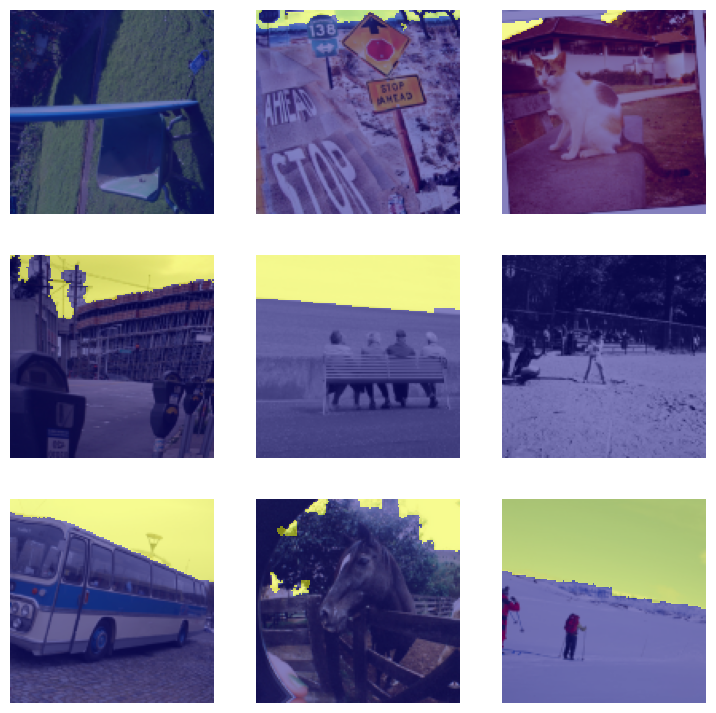

In [8]:
bs = 16
dls = get_dls(bs, 128)
dls.show_batch(cmap='plasma', vmin=0, vmax=1)


# Unet training

- Note : fp16 (mixed precision) model training has been tried, but something wrong as loss is always NaN on my machine (is it a graphic card issue?)

- Pick a resnet18 as architecture as it is small and 'fast' to train



In [9]:
# SqueezeNet resnet18 resnet34 mobilenet_v3_small
learn = unet_learner(dls, resnet18)

/home/cstrauss/anaconda3/envs/progo/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/cstrauss/anaconda3/envs/progo/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Find the learning rate

Don't get too high or it will diverge, don't get too low or it will be slow to converge

for Unet with Resnet18, bs=4, res=224, LR is in the 1e-5 - 1e-4 range 

SuggestedLRs(valley=6.30957365501672e-05)

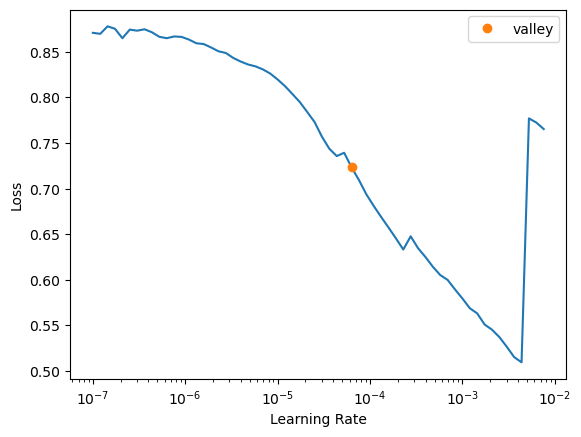

In [10]:

learn.lr_find()

# Train with Progressive resizing

For faster training : start at lower resolution for the firsts epochs then move to the targeted size

- see https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb for exemple

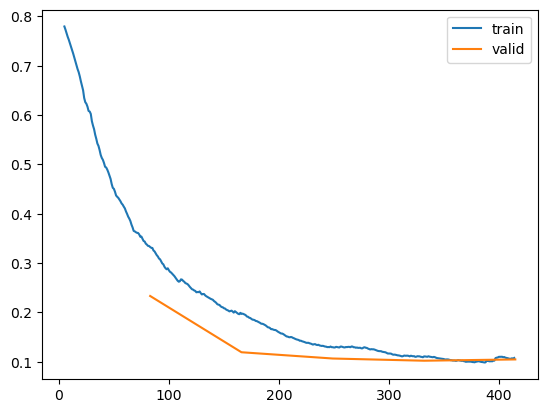

In [11]:
learn.dls = get_dls(16, 112)
learn.freeze() # do not train the pretrained part
learn.fit_one_cycle(5, 1e-4)
learn.recorder.plot_loss()

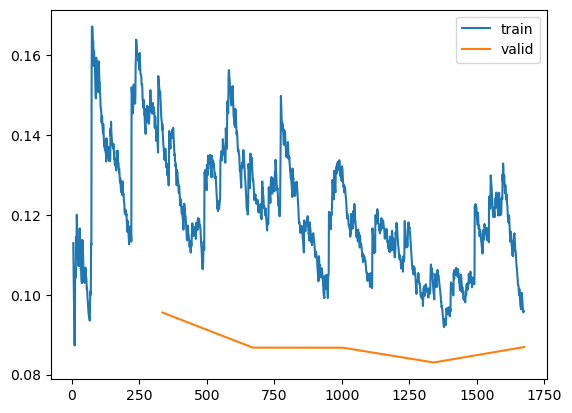

In [12]:
learn.dls = get_dls(4, 224)
learn.freeze()
learn.fit_one_cycle(5, 1e-5)
learn.recorder.plot_loss()

Here is the code for fine_tune

```
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `freeze` for `freeze_epochs` then with `unfreeze` from `epochs` using discriminative LR"
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)

```

- Note : fine_tune unfreeze the model : it also train the pretrained part

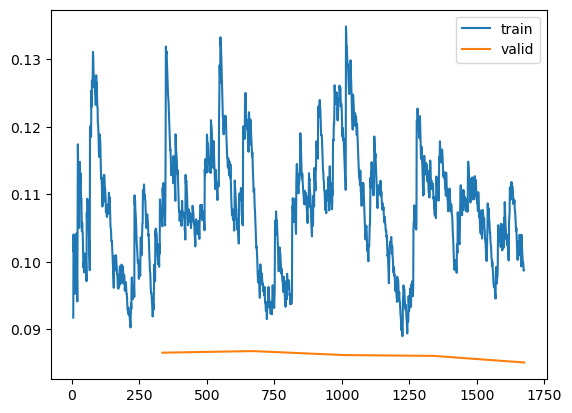

In [13]:
learn.fine_tune(5, 1e-6)
learn.recorder.plot_loss()

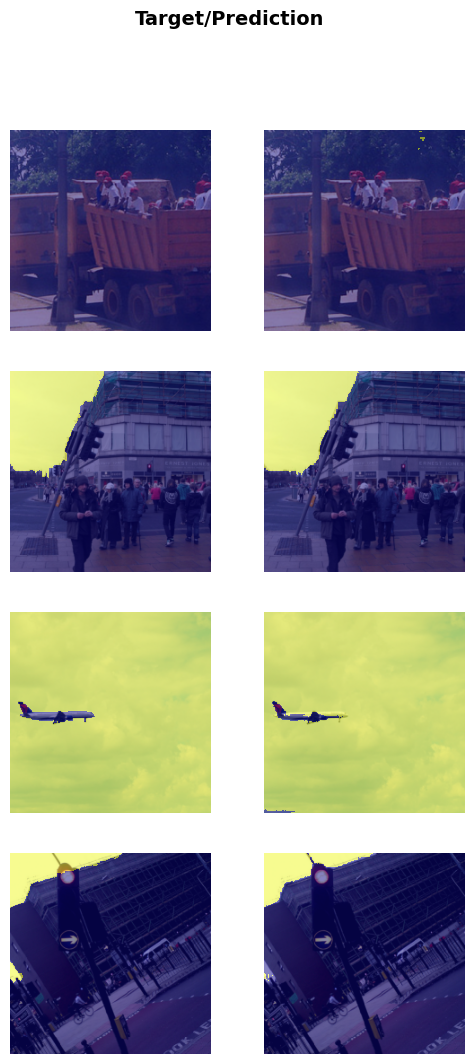

In [14]:
learn.show_results(cmap='plasma', vmin=0, vmax=1, shuffle=False)

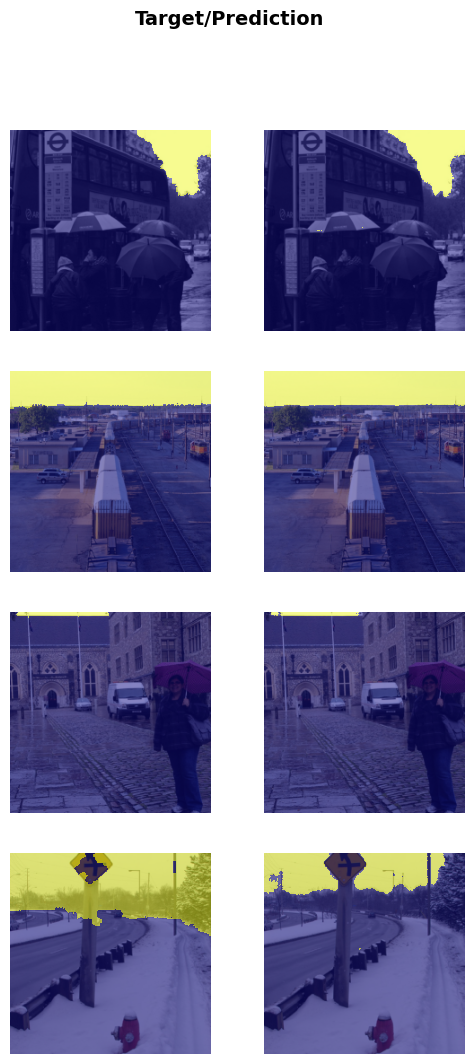

In [16]:
learn.show_results(cmap='plasma', vmin=0, vmax=1)


In [17]:
learn.save ("freezedModel.fastai")


Path('models/freezedModel.fastai.pth')

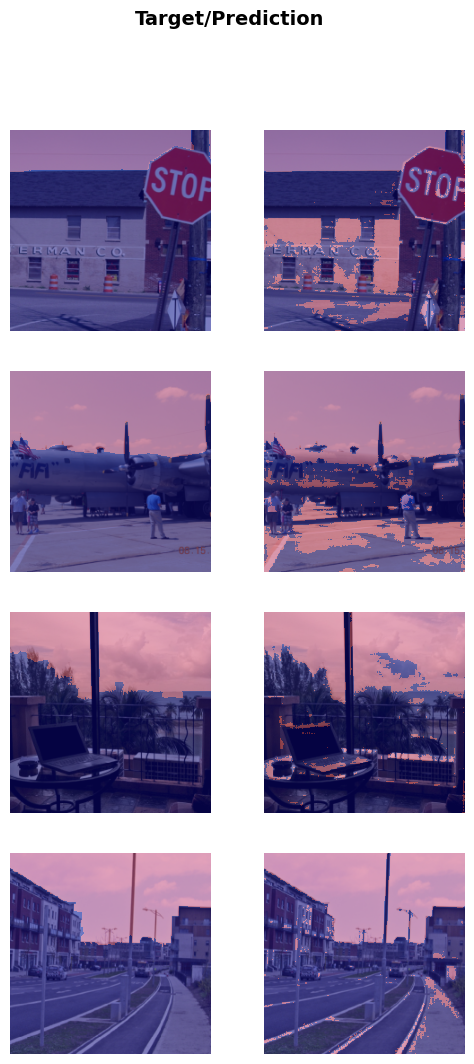

In [18]:
dls2  = get_dls(4, 224)
learn2 = unet_learner(dls2, resnet18)
learn2 = learn2.load("freezedModel.fastai")
learn2.show_results(cmap='plasma')

### Shows the worst result

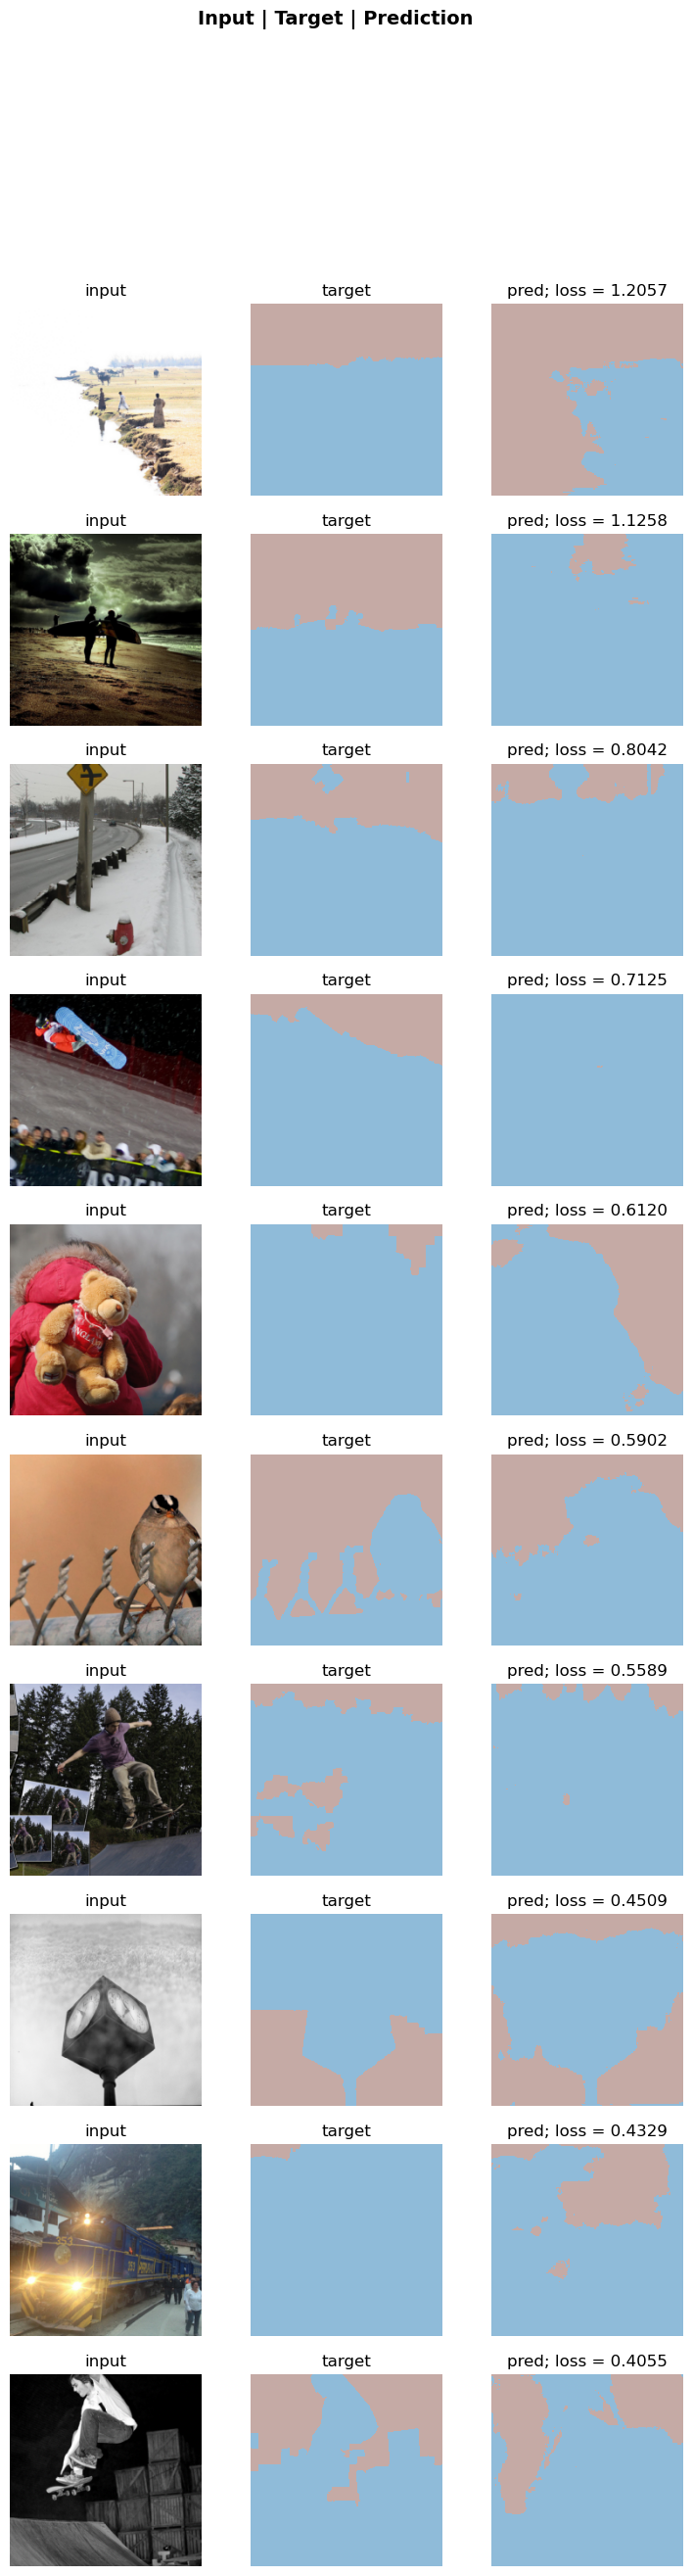

In [19]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=10)

### Utils function to be moved elsewhere eventually

In [34]:
def showImageAndMask(img: PILImage, pred, justThePair = False) :
    """Show the segmentation result on the image

    Args:
        img (PILImage): rgb image
        pred (Tensor): prediction out of .predict function
        justThePair (bool, optional): when true it gives a smaller display. Defaults to False.
    """
    mask = Image.fromarray(np.uint8(pred) * 255) 
    mask = mask.resize(img.size, resample=NEAREST)


    skyIdx =  np.array(mask, dtype=np.uint8) > 0
    masked_img = np.array(img, dtype=np.uint8)

    masked_img[skyIdx] =  masked_img[skyIdx] * 0.3#   [255, 0, 255]

    if  justThePair :
        plt.figure()
        f, axarr = plt.subplots(1,2, figsize=(10, 10)) 
        axarr[0].imshow(img, cmap="gray")
        axarr[1].imshow(masked_img, cmap="gray")
    else :
        plt.figure()
        f, axarr = plt.subplots(1,3, figsize=(15, 15)) 
        axarr[0].imshow(img, cmap="gray")
        axarr[1].imshow(mask, cmap="gray")
        axarr[2].imshow(masked_img, cmap="gray")

        plt.figure(figsize=(15, 15))
        plt.imshow(masked_img, cmap="gray")

In [48]:

normalizer = Normalize.from_stats(*imagenet_stats)

def predictAndDisplay(image_path:str, simple=True):
    """Open the image, run prediction and Display result for a image Path

    Args:
        image_path (str): path of the image
        simple (bool, optional):  when true it gives a smaller display. Defaults to False.
    """
   
    img = PILImage.create(image_path)
   
  
    #preprocess and normalized opened image
    #img_tensor = normalizer.encodes(img)

    # Get the prediction
    with learn.no_bar(), learn.no_logging():
        pred, label, prob = learn.predict(img)

    showImageAndMask(img, pred, simple)

/tmp/ipykernel_375665/583337779.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 640x480 with 0 Axes>

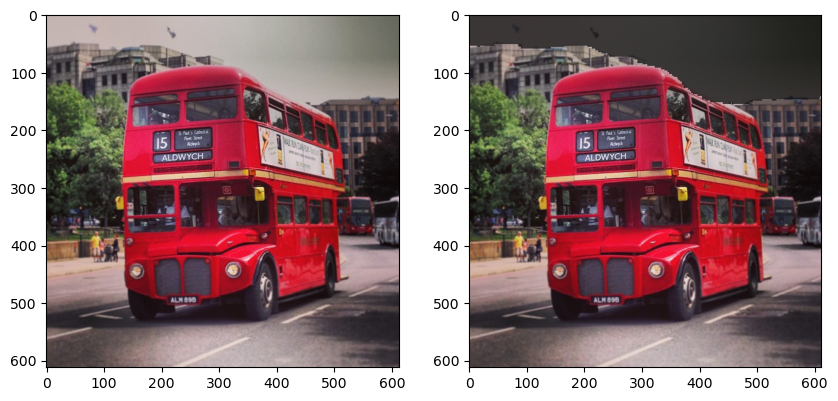

<Figure size 640x480 with 0 Axes>

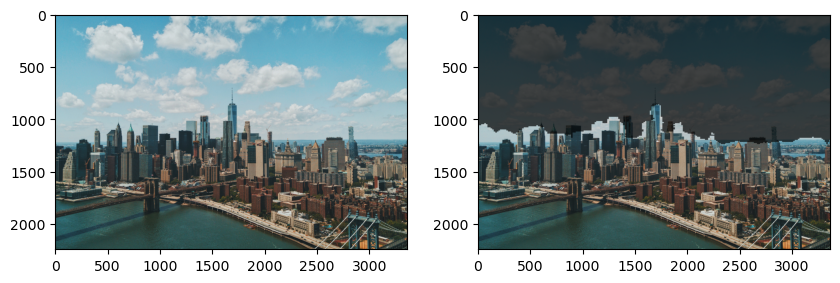

<Figure size 640x480 with 0 Axes>

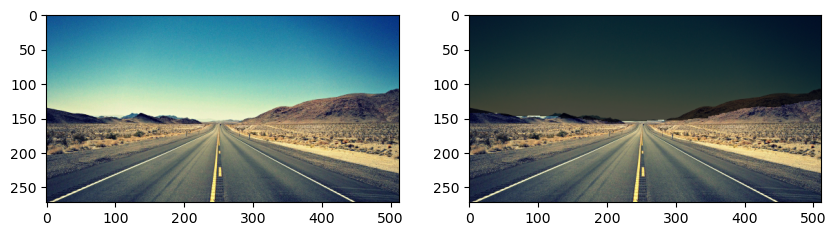

<Figure size 640x480 with 0 Axes>

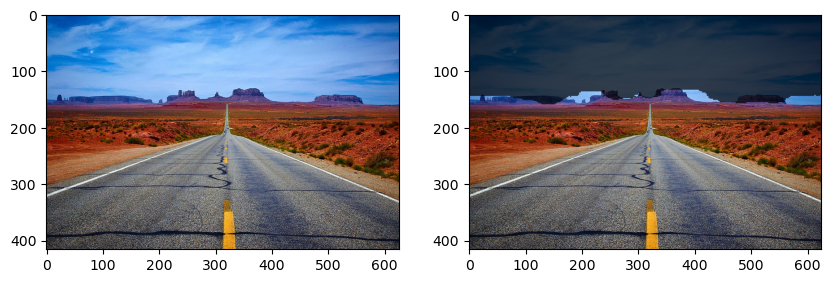

<Figure size 640x480 with 0 Axes>

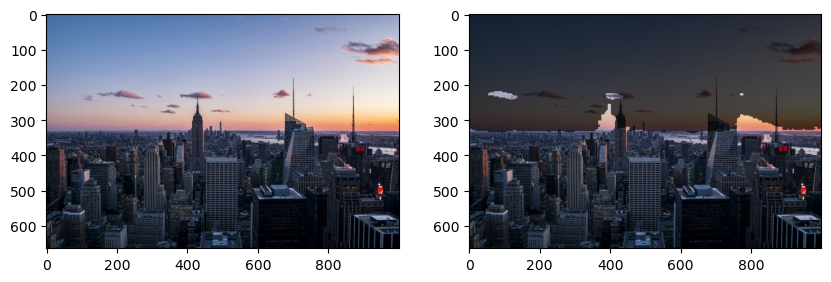

<Figure size 640x480 with 0 Axes>

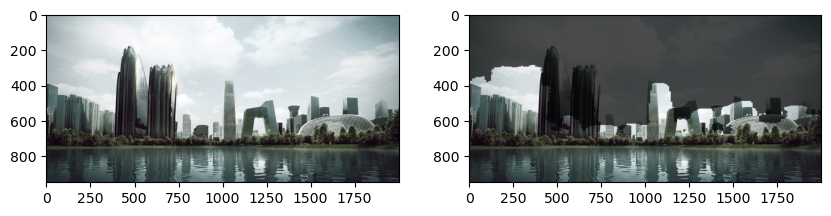

<Figure size 640x480 with 0 Axes>

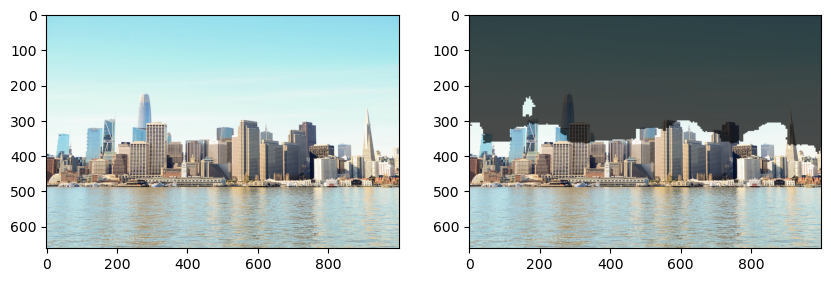

<Figure size 640x480 with 0 Axes>

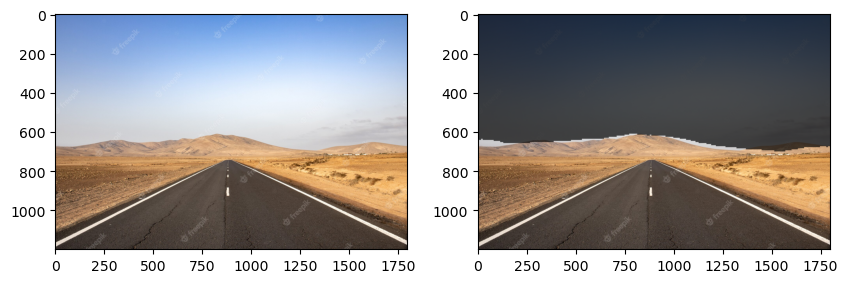

<Figure size 640x480 with 0 Axes>

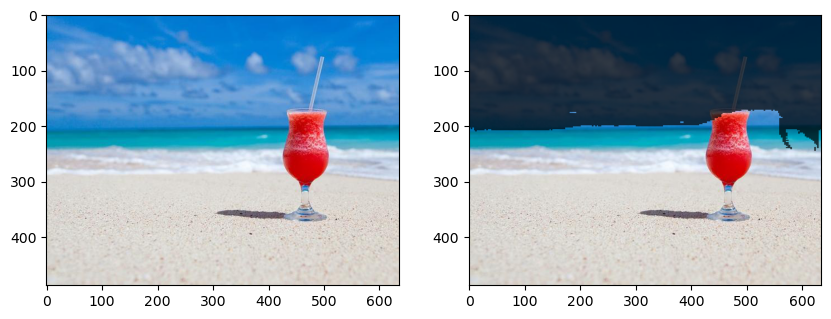

<Figure size 640x480 with 0 Axes>

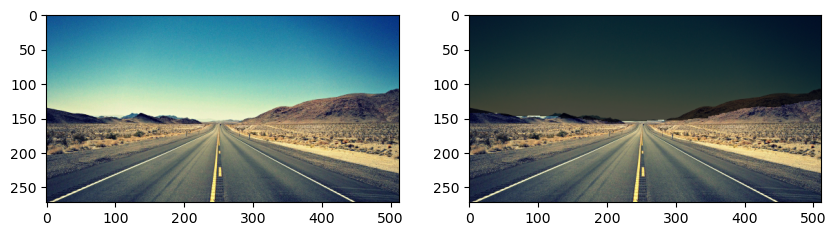

<Figure size 640x480 with 0 Axes>

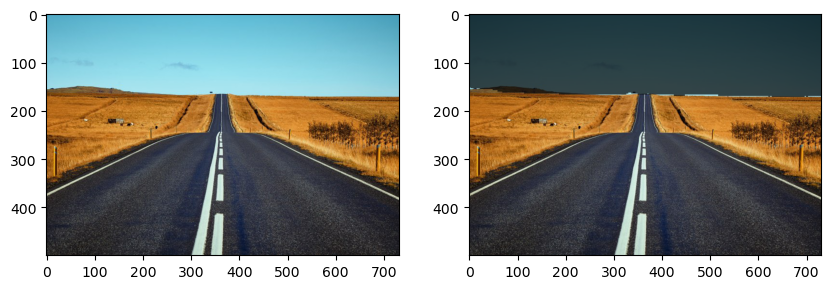

<Figure size 640x480 with 0 Axes>

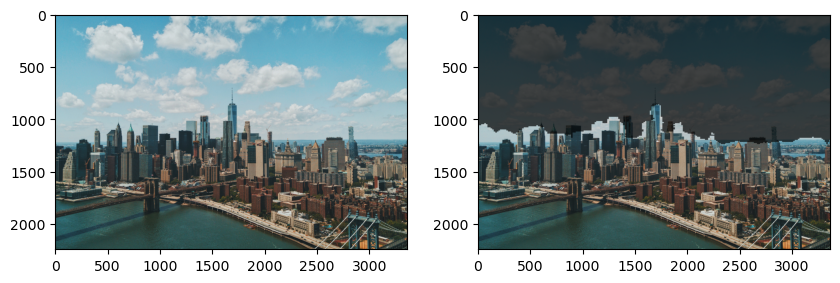

<Figure size 640x480 with 0 Axes>

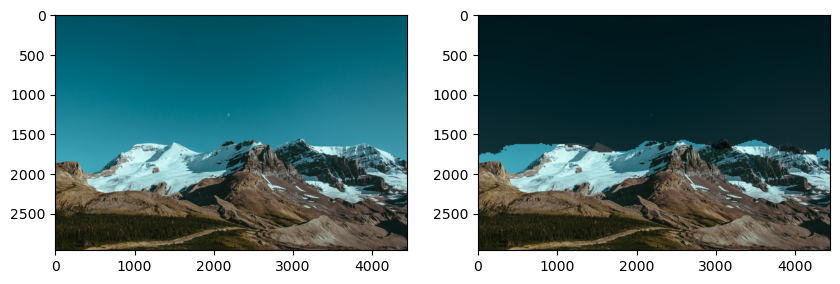

<Figure size 640x480 with 0 Axes>

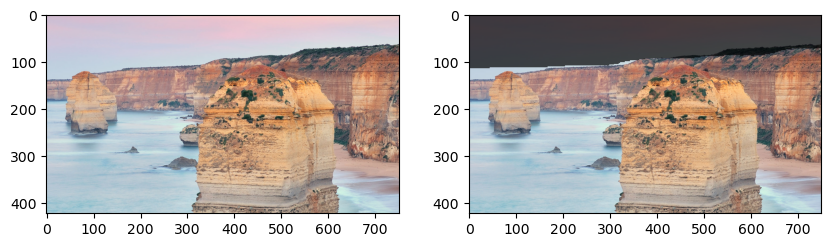

<Figure size 640x480 with 0 Axes>

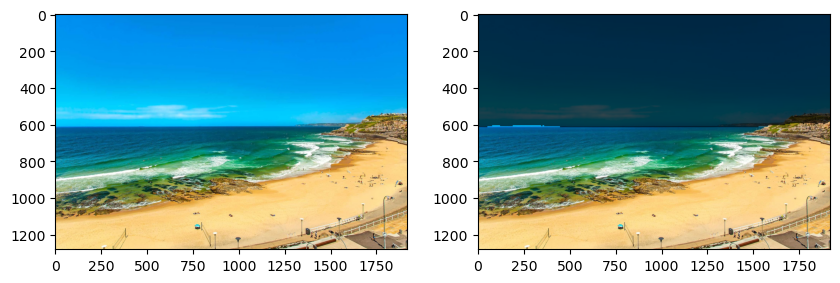

<Figure size 640x480 with 0 Axes>

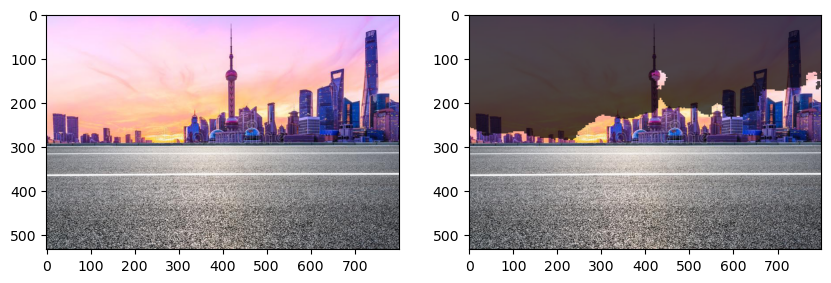

In [49]:
# Load the image
#predictAndDisplay('../TestImages/patrick-tomasso-SVVTZtTGyaU-unsplash.jpg')
predictAndDisplay('/home/cstrauss/PERSO/progo/orpogSkySeg/00_Dataset/cocoSky/000000001584.jpg')
predictAndDisplay('../TestImages/patrick-tomasso-SVVTZtTGyaU-unsplash.jpg')
predictAndDisplay('../TestImages/exemple1.png')

for path in glob.glob('../TestImages/*') :
    predictAndDisplay(path)


# Slidding Window

(841, 560) 4 3
(4, 3, 224, 224)


/tmp/ipykernel_375665/1260405265.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


(784, 1065)


<Figure size 640x480 with 0 Axes>

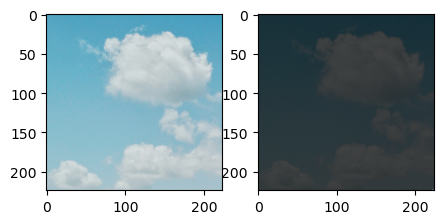

<Figure size 640x480 with 0 Axes>

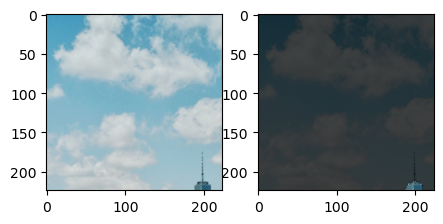

<Figure size 640x480 with 0 Axes>

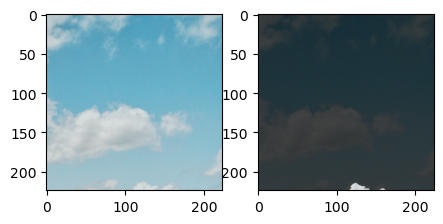

<Figure size 640x480 with 0 Axes>

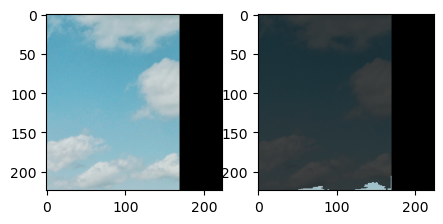

<Figure size 640x480 with 0 Axes>

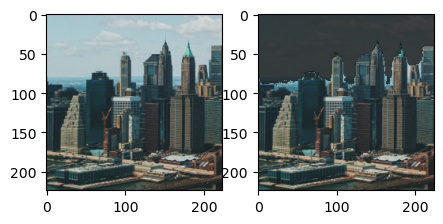

<Figure size 640x480 with 0 Axes>

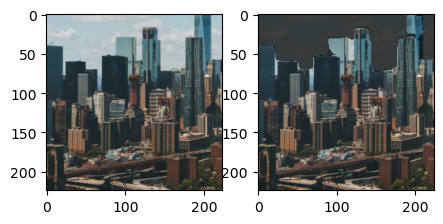

<Figure size 640x480 with 0 Axes>

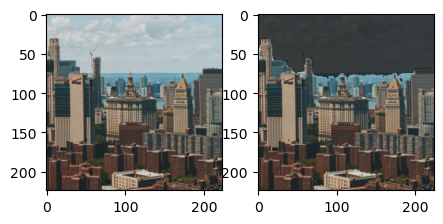

<Figure size 640x480 with 0 Axes>

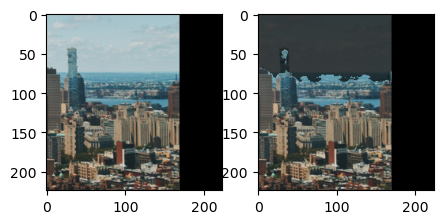

<Figure size 640x480 with 0 Axes>

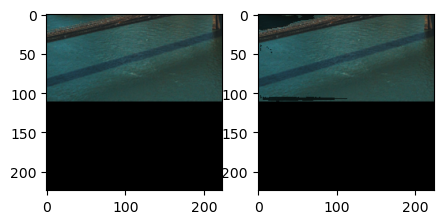

<Figure size 640x480 with 0 Axes>

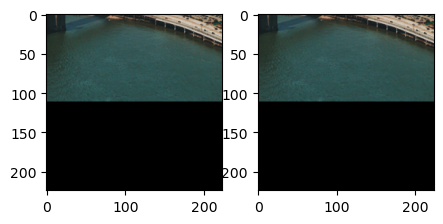

<Figure size 640x480 with 0 Axes>

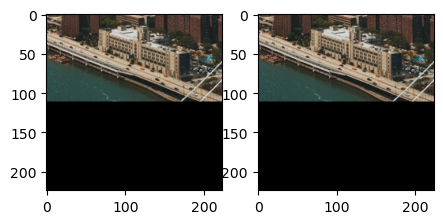

<Figure size 640x480 with 0 Axes>

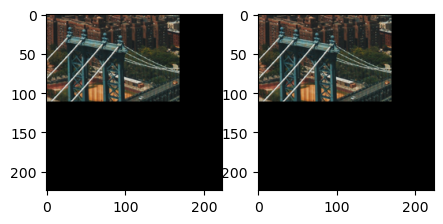

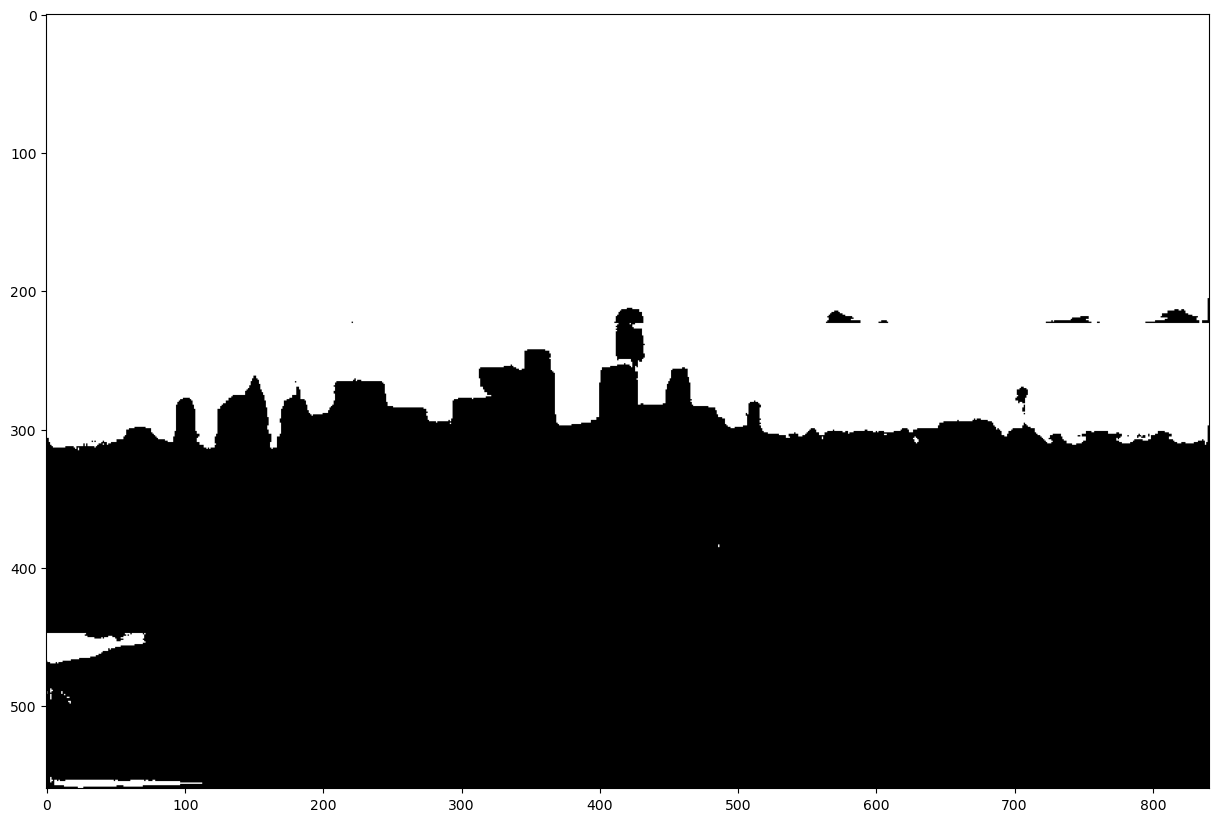

<Figure size 640x480 with 0 Axes>

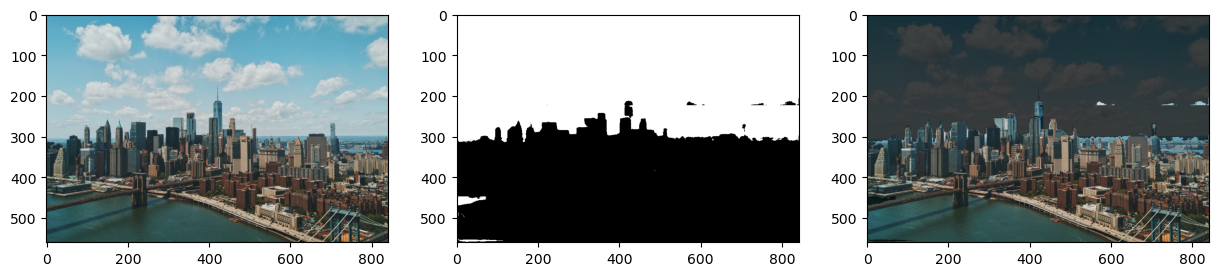

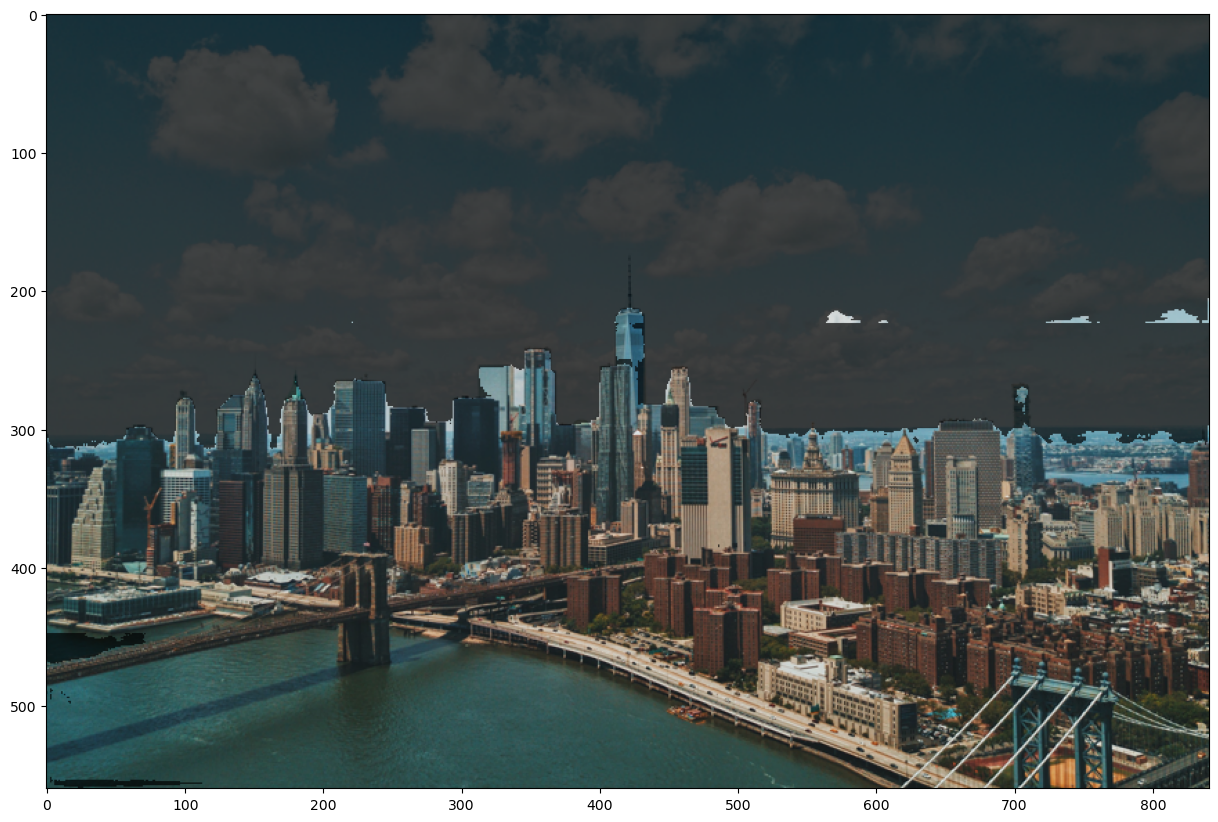

In [26]:

# Imports PIL module 
from PIL import Image
  
# Load the large image
img =  Image.open(r'../TestImages/patrick-tomasso-SVVTZtTGyaU-unsplash.jpg')
width, height = img.size

if(width > 1920):
    img = img.resize((width//4,height//4))

img_tensor = normalizer.encodes(img)

# Define the patch size and stride
patch_size = 224
stride = patch_size

# Calculate the number of patches in each dimension
w, h = img.size 
n_patches_w = int(np.ceil((w - patch_size) / stride)) + 1
n_patches_h = int(np.ceil((h - patch_size) / stride)) + 1

w = w + patch_size
h = h + patch_size

print(img.size , n_patches_w, n_patches_h)
# Create an empty array to store the predicted patches
pred_patches = np.zeros((n_patches_w, n_patches_h, patch_size, patch_size))

print( pred_patches.shape)


# Iterate over the patches and make predictions
for j in range(n_patches_h):
    for i in range(n_patches_w):
        # Calculate the coordinates of the patch
        x1 = i * stride
        x2 = x1 + patch_size
        y1 = j * stride
        y2 = y1 + patch_size
        
        # Extract the patch from the image
        patch = img.crop((x1, y1, x2, y2))
   
        img_tensor = normalizer.encodes(np.array(img_tensor))       
    
        # Make a prediction using the U-Net model
        with learn.no_bar(), learn.no_logging():
            pred = learn.predict(PILImage(patch))[0]
        
        showImageAndMask(patch, pred, true)

        # Store the predicted patch in the array
        pred_patches[i, j] = pred.data.numpy()

# Stitch the predicted patches back together to create the final prediction
pred = np.zeros((h, w))
print( pred.shape)
for j in range(n_patches_h):
    for i in range(n_patches_w):
        # Calculate the coordinates of the patch
        x1 = i * stride
        x2 = x1 + patch_size
        y1 = j * stride
        y2 = y1 + patch_size
        
        # Add the patch to the final prediction
        pred[y1:y2, x1:x2] += pred_patches[i, j]

# Normalize the final prediction
pred /= np.max(pred)

# Convert the prediction to a PIL Image and save it
pred = (pred * 255).astype(np.uint8)
pred_img = Image.fromarray(pred)
w, h = img.size 
pred_img = pred_img.crop((0, 0, w, h))
pred_img.save('test.png')

plt.figure(figsize=(15, 15))
plt.imshow(pred_img, cmap="gray")

showImageAndMask(img, pred_img)


In [27]:
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
from tqdm import tqdm


def confusion_matrix(
    learn: Learner,
    dl: DataBlock.dataloaders
) -> [np.ndarray, np.ndarray]:
    """ Compute confusion matrix.

    Args:
        learn: trained model
        dl: dataloader with images and ground truth masks

    Return:
        The un-normalized and the normalized confusion matrices.
    """
    y_gts = []
    y_preds = []

    # Loop over all images
    with tqdm(total=len(dl.items)) as pbar:
        for im_path in dl.items:
            pbar.update(1)
            img = PILImage.create(im_path)
            gt_mask = dl.tfms[1](im_path)
            with learn.no_bar(), learn.no_logging():
                pred_mask, _, _ = learn.predict(img)

            pred_mask = Image.fromarray(np.uint8(pred_mask))
            pred_mask = pred_mask.resize(gt_mask.size, resample=NEAREST)

            gt_mask = np.array(gt_mask, dtype=np.uint8)
            pred_mask = np.array(pred_mask, dtype=np.uint8)

            # Store predicted and ground truth labels
            assert len(gt_mask.flatten()) == len(pred_mask.flatten())

            y_gts.extend(gt_mask.flatten())
            y_preds.extend(pred_mask.flatten())

    # Compute confusion matrices

    cmat = sk_confusion_matrix(y_gts, y_preds)
    cmat_norm = sk_confusion_matrix(y_gts, y_preds, normalize="true")

    return cmat, cmat_norm


In [28]:
cmat, cmat_norm = confusion_matrix(learn, dls.valid_ds)


#accs = print_accuracies(cmat, cmat_norm, classes)

100%|██████████| 335/335 [00:25<00:00, 13.03it/s]


In [29]:
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import cm

def plot_confusion_matrix(
    cmat: np.ndarray,
    cmat_norm: np.ndarray,
    classes: List[str],
    show: bool = True,
    figsize: Tuple[int, int] = (16, 4),
) -> None:
    """ Plot the confusion matrices.

    Args:
        cmat: confusion matrix (with raw pixel counts)
        cmat_norm: normalized confusion matrix
        classes: list of class names
        show: set to true to call matplotlib's show()
        figsize: figure size
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ConfusionMatrixDisplay(confusion_matrix = cmat, display_labels = classes).plot(
        ax=ax1,
        cmap=cm.get_cmap("Blues"),
        xticks_rotation="vertical",
        values_format="d",
    )
    ConfusionMatrixDisplay(confusion_matrix = cmat_norm, display_labels = classes).plot(
        ax=ax2, cmap=cm.get_cmap("Blues"), xticks_rotation="vertical"
    )
    ax1.set_title("Confusion matrix")
    ax2.set_title("Normalized confusion matrix")

    if show:
        plt.show()

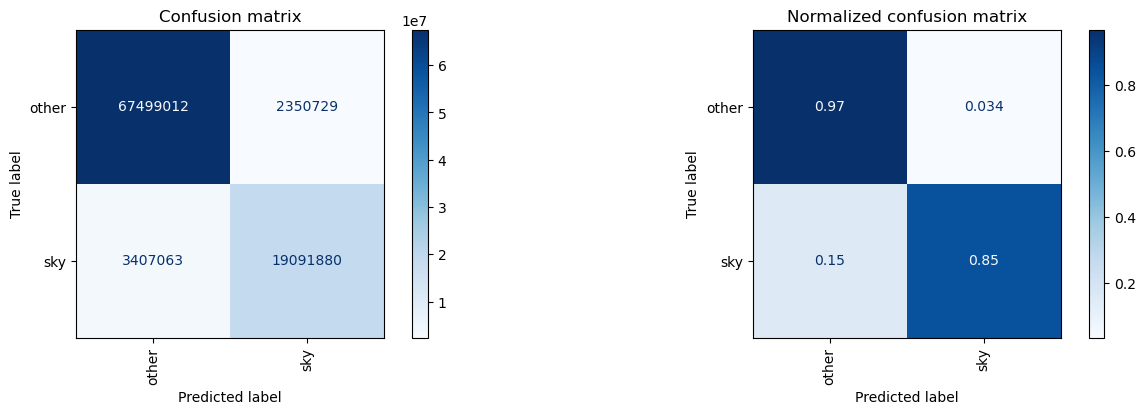

In [30]:
#accs = print_accuracies(cmat, cmat_norm, classes)
plot_confusion_matrix(cmat, cmat_norm, (['other', 'sky']))

## TODO 

- save the test image list (save the path)
- move confusion matrix code to lib
- build an evaluator from image + gtMask + prediction folder
- update the cpp to save a binary mask
- evaluate the cpp solution on the same test images

- train and evaluate on ADE20K